In [3]:
import sys
import os

sys.path.insert(0, "..")

import csv
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from functools import partial
from datetime import datetime
from torchvision import transforms

from dinov2.data import SamplerType, make_data_loader, make_dataset
from dinov2.data import collate_data_and_cast, DataAugmentationDINO, MaskingGenerator
import dinov2.distributed as distributed

/home/jluesch/micromamba/envs/dinov2/lib/python3.9/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/jluesch/micromamba/envs/dinov2/lib/python3.9/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submi

In [4]:
train_ds_path = "HDF5Dataset:split=TRAIN:root=/home/jluesch/Documents/data/plankton/2007-TRAIN.hdf5:extra=*"
img_size = 224
patch_size = 14
n_tokens = (img_size // patch_size) ** 2
inputs_dtype = torch.half
do_on_gpu = True
do_data_aug = False

mask_generator = MaskingGenerator(
    input_size=(img_size // patch_size, img_size // patch_size),
    max_num_patches=0.5 * img_size // patch_size * img_size // patch_size,
)

if not do_on_gpu and do_data_aug:
    data_transform = DataAugmentationDINO(
        (0.32, 1.0),
        (0.05, 0.32),
        8,
        global_crops_size=224,
        local_crops_size=96,
    )
    data_transform_gpu = None
elif do_data_aug:
    data_transform_cpu = transforms.ToTensor()
    data_transform_gpu = DataAugmentationDINO(
        (0.32, 1.0),
        (0.05, 0.32),
        8,
        global_crops_size=224,
        local_crops_size=96,
        do_transform_on_gpu=True,
    )
else:
    data_transform_cpu = transforms.ToTensor()
    data_transform_gpu = None

collate_fn = partial(
    collate_data_and_cast,
    mask_ratio_tuple=(0.1, 0.5),
    mask_probability=0.5,
    n_tokens=n_tokens,
    mask_generator=mask_generator,
    dtype=inputs_dtype,
)

# setup data loader
dataset = make_dataset(
    dataset_str=train_ds_path,
    transform=data_transform_cpu,
    target_transform=lambda _: (),
)

print(f"#samples: {len(dataset)}")

Dataset kwargs {'split': <_SplitHDF5Dataset.TRAIN: 'train'>, 'root': '/home/jluesch/Documents/data/plankton/2007-TRAIN.hdf5', 'extra': '*', 'do_short_run': False}
root: /home/jluesch/Documents/data/plankton/2007-TRAIN.hdf5, extra_root: *, extra_path: /home/jluesch/Documents/data/plankton/2007-TRAIN.hdf5
Datasets file list:  ['/home/jluesch/Documents/data/plankton/2007-TRAIN.hdf5']
#unique_class_ids: _SplitHDF5Dataset.TRAIN, 88
#unique_class_names: ['Amphidinium_sp' 'Asterionellopsis' 'Bidulphia' 'Cerataulina' 'Ceratium'
 'Chaetoceros' 'Chaetoceros_didymus' 'Chaetoceros_flagellate'], 88
#samples: 289020


In [11]:
batch_size_list = [32, 64, 128, 256, 512]
num_workers_list = [2, 4]
MAX_NB_SAMPLE = 50000
verbose = False
erase_preexisting_entries = False

res_file_path = f"./dataloader_benchmark_results_{MAX_NB_SAMPLE}_gpu{do_on_gpu}_dataaug{do_data_aug}.csv"

if erase_preexisting_entries:
    with open(res_file_path, "w", newline="") as csvfile:
        csvwriter = csv.writer(csvfile, delimiter=",")
        csvwriter.writerow(
            [
                "batch_size",
                "num_workers",
                "tot_time",
                "mean_batch",
                "std_batch",
                "min_batch",
                "max_batch",
                "nb_iters",
                "MAX_NB_SAMPLE",
                "do_data_aug",
            ]
        )

with open(res_file_path, "a", newline="") as csvfile:
    csvwriter = csv.writer(csvfile, delimiter=",")

    for num_workers in num_workers_list:
        for batch_size in batch_size_list:
            # sampler_type = SamplerType.INFINITE
            sampler_type = SamplerType.SHARDED_INFINITE
            if not do_on_gpu:
                data_loader = make_data_loader(
                    dataset=dataset,
                    batch_size=batch_size,
                    num_workers=num_workers,
                    shuffle=True,
                    seed=0,
                    sampler_type=sampler_type,
                    sampler_advance=0,  # TODO(qas): fix this -- start_iter * cfg.train.batch_size_per_gpu,
                    drop_last=True,
                    collate_fn=collate_fn,
                )
            else:
                data_loader = make_data_loader(
                    dataset=dataset,
                    batch_size=batch_size,
                    num_workers=num_workers,
                    shuffle=True,
                    seed=0,  # TODO: Fix this -- cfg.train.seed
                    sampler_type=sampler_type,
                    sampler_advance=0,  # TODO(qas): fix this -- start_iter * cfg.train.batch_size_per_gpu,
                    drop_last=True,
                    collate_fn=None,
                )

            start_t = datetime.now().timestamp()

            batch_delta_ts = []
            batch_start_t = datetime.now().timestamp()
            for i, data in enumerate(data_loader):
                if data_transform_gpu is not None:
                    # current_device_nb = model.student.backbone.device
                    if isinstance(data, list):
                        data = data[0].to(device=f"cuda:{torch.cuda.current_device()}")

                    data = data_transform_gpu(data)
                    data = collate_fn(data)  # collate_fn collates crops and computes masks tensors
                    # TODO: teacher crops are not used????

                    data = {
                        k: (
                            v.to(device=f"cuda:{torch.cuda.current_device()}")
                            if torch.is_tensor(v) and not v.is_cuda
                            else v
                        )
                        for k, v in data.items()
                    }
                batch_end_t = datetime.now().timestamp()

                batch_delta_t = batch_end_t - batch_start_t
                batch_delta_ts.append(batch_delta_t)

                if verbose or i % 100 == 0:
                    print(f"{i}, {i*batch_size}: {batch_delta_t:.5}")
                if verbose:
                    print(data["collated_masks"].shape)
                    print(data["mask_indices_list"].shape)
                    print(data["masks_weight"].shape)
                    print(data["upperbound"], data["n_masked_patches"])

                batch_start_t = datetime.now().timestamp()

                if i * batch_size >= MAX_NB_SAMPLE:
                    end_t = datetime.now().timestamp()
                    break

            total_t = end_t - start_t
            mean_batch = np.mean(batch_delta_ts[2:])  # remove first 2 steps
            std_batch = np.std(batch_delta_ts[2:])
            max_batch = np.max(batch_delta_ts[2:])
            min_batch = np.min(batch_delta_ts[2:])
            print(f"BATCH SIZE {batch_size}, NUM WORKERS {num_workers}, TIME TOTAL: {total_t:.5}")
            print(f"PER BATCH: {mean_batch:.5} ± {std_batch:.5}, max {max_batch:.5}, min {min_batch:.5}")
            print(
                f"TIME PER SAMPLE: {mean_batch/batch_size:.5} ± {std_batch/batch_size:.5}, max {max_batch/batch_size:.5}, min {min_batch/batch_size:.5}"
            )
            print()
            csvwriter.writerow(
                [batch_size, num_workers, total_t, mean_batch, std_batch, min_batch, max_batch, i, MAX_NB_SAMPLE]
            )
            csvfile.flush()

0, 0: 2.5837
100, 3200: 0.0096061
200, 6400: 0.010557
300, 9600: 0.009799
400, 12800: 0.0090928
500, 16000: 0.009392
600, 19200: 0.0005641
700, 22400: 0.0096059
800, 25600: 0.009362
900, 28800: 0.009094
1000, 32000: 0.0098059
1100, 35200: 0.018966
1200, 38400: 0.009928
1300, 41600: 0.008117
1400, 44800: 0.0093482
1500, 48000: 0.018843
BATCH SIZE 32, NUM WORKERS 8, TIME TOTAL: 18.297
PER BATCH: 0.010042 ± 0.0044371, max 0.050031, min 8.3923e-05
TIME PER SAMPLE: 0.00031382 ± 0.00013866, max 0.0015635, min 2.6226e-06

0, 0: 2.7054
100, 6400: 0.02239
200, 12800: 0.019926
300, 19200: 0.02047
400, 25600: 0.020171
500, 32000: 0.039731
600, 38400: 0.02009
700, 44800: 0.018959
BATCH SIZE 64, NUM WORKERS 8, TIME TOTAL: 17.898
PER BATCH: 0.01938 ± 0.010475, max 0.13391, min 6.8903e-05
TIME PER SAMPLE: 0.00030281 ± 0.00016367, max 0.0020923, min 1.0766e-06

0, 0: 2.8045
100, 12800: 0.03916
200, 25600: 0.039513
300, 38400: 0.042293
BATCH SIZE 128, NUM WORKERS 8, TIME TOTAL: 18.13
PER BATCH: 0.03916

In [12]:


timing_df = pd.read_csv(res_file_path)

timing_df = timing_df[['batch_size', 'num_workers', 'tot_time']]

timing_df.set_index(['batch_size', 'num_workers'])


,,tot_time
batch_size,num_workers,
32,8,18.296959
64,8,17.897950
128,8,18.130205
256,8,17.617762
512,8,17.816417
32,16,18.810465
64,16,19.432258
128,16,18.494297
256,16,17.326411


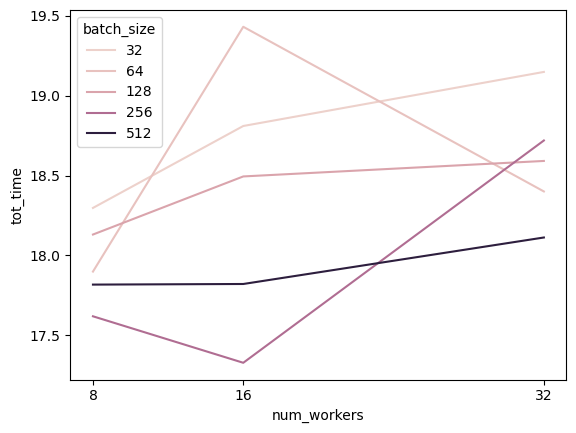

In [13]:
sns.lineplot(timing_df, x="num_workers", y="tot_time", hue="batch_size")
plt.xticks(timing_df["num_workers"].unique())

os.makedirs(res_file_path[:-4], exist_ok=True)
save_fig_path = os.path.join(res_file_path[:-4], "time_vs_num_workers_workstation.png")
plt.savefig(save_fig_path, dpi=300)
plt.show()